## Connect


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!gdown 1y333j9Aqf-kxLOHYReMankKCl309EObA
!unzip /content/makeup_data.zip

## Import Module/Library

In [ ]:
import os
import sys
import glob
import numpy as np
import matplotlib.pyplot as plt

!pip install -qqq -U rich

!pip install -qqq ipywidgets

import gc
import rich
from rich.progress import track
import torch
import torchvision
from torchvision.utils import make_grid
from torchvision.transforms.functional import resize
import torch.nn as nn
from torch.utils.data import DataLoader
!pip install -qqq torchmetrics
import torchmetrics
!pip install -qqq torchsummary
from torchsummary import summary
import torch.nn.functional as F
from torch import optim
from PIL import Image
from torchvision import transforms as T
from torchvision import models
!pip install -qqq graphviz
!pip install -qqq torchviz
from torchviz import make_dot

import warnings
warnings.filterwarnings('ignore')

print(f'Pytorch version: {torch.__version__}')
print(f'Python version: P{sys.version}')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Pytorch version: 2.0.0+cu118
Python version: P3.9.16 (main, Dec  7 2022, 01:11:51) 
[GCC 9.4.0]


## Config Parameters

In [ ]:
IMG_PATH = "/content/makeup_data"

class cfg:
    IMG_HEGIHT  = 224
    IMG_WIDHT   = 224
    IMG_CHANNEL = 3
    BATCH_SIZE = 32
    epochs = 150
    num_workers = 4
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

##  Load Data

In [ ]:
train_dir = '/content/makeup_data/train'
val_dir = '/content/makeup_data/val'
test_dir = '/content/makeup_data/test'

def file_list(data_dir):
    file_list = []
    file_list += glob.glob(os.path.join(data_dir + '/', '*.png'))
    return file_list

In [ ]:
def load(image_file):
    image = torchvision.io.read_image(image_file)
    
    # Split each image tensor into two tensors:
    # - non-makeup image
    # - makeup image
    w = image.size()[2]
    w = w // 3
    input_image  = image[:, :, w*2:w*3]
    target_image = image[:, :, w:w*2]

    input_image  = resize(input_image, [cfg.IMG_HEGIHT, cfg.IMG_WIDHT])
    target_image = resize(target_image, [cfg.IMG_HEGIHT, cfg.IMG_WIDHT])
    
    # Convert both images to float32 tensors
    input_image  = input_image.float()
    target_image = target_image.float()
    
    return input_image, target_image

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


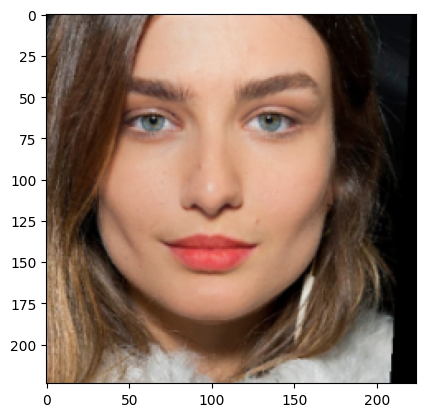

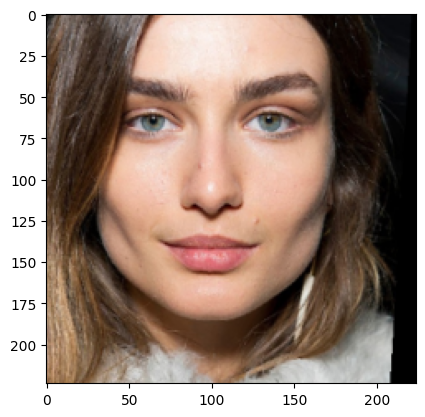

In [ ]:
input_image, target_image = load(str(IMG_PATH + '/train/0.png'))
print(input_image.shape)
print(target_image.shape)


# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(input_image.permute(1,2,0)/255)
plt.figure()
plt.imshow(target_image.permute(1,2,0)/255)


In [ ]:
class dataset(torch.utils.data.Dataset):
    """Some Information about dataset"""
    def __init__(self, file_list, train=True):
        self.file_list = file_list
        self.train = train
        self.normalize = T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
        
    def __getitem__(self, index):
        
        img_path = self.file_list[index]
        input_image, target_image = load(img_path)
        if self.train == True:
            if torch.rand(()) > 0.5:
                # Random mirroring
                input_image = torch.fliplr(input_image)
                target_image = torch.fliplr(target_image)
            input_image = self.normalize(input_image/255.0)
            target_image = (target_image / 255.0)
            return input_image, target_image
        else: 
            input_image = self.normalize(input_image/255.0)
            target_image = (target_image / 255.0)
            return input_image, target_image

    def __len__(self):
        return len(self.file_list)

In [ ]:
invTrans = T.Compose([T.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                      T.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ])])

In [ ]:
train_data = dataset(file_list(train_dir), train=True)
valid_data = dataset(file_list(val_dir), train=False)
test_data = dataset(file_list(test_dir), train=False)

In [ ]:
train_loader = DataLoader(dataset=train_data, batch_size=cfg.BATCH_SIZE, shuffle=True, num_workers=cfg.num_workers, pin_memory=True)
valid_loader = DataLoader(dataset=valid_data, batch_size=cfg.BATCH_SIZE, shuffle=True, num_workers=cfg.num_workers, pin_memory=True)
test_loader = DataLoader(dataset=test_data, batch_size=cfg.BATCH_SIZE, shuffle=True, num_workers=cfg.num_workers, pin_memory=True)


## Build Model 

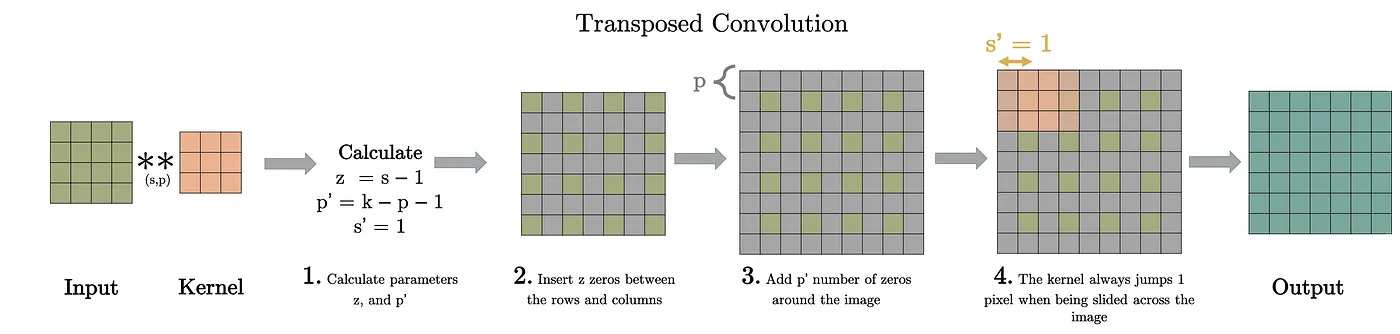

In [ ]:
class res50Unet(nn.Module):
    """Some Information about res50Unet"""
    def __init__(self):
        super(res50Unet, self).__init__()

        self.backbone = models.resnet50(pretrained=True)

        # input: [1, 3, 224, 224]
        self.enb0 = nn.Sequential(*list(self.backbone.children())[:4]).requires_grad_(False) # [1, 64, 56, 56]
        self.enb1 = self.backbone.layer1.requires_grad_(False) # [1, 256, 56, 56]
        self.enb2 = self.backbone.layer2.requires_grad_(False) # [1, 512, 28, 28]
        self.enb3 = self.backbone.layer3.requires_grad_(False) # [1, 1024, 14, 14]

        self.bridge = self.backbone.layer4.requires_grad_(False) # [1, 2048, 7, 7]

        self.deb3 = nn.ConvTranspose2d(2048, 1024, kernel_size=2, stride=2, padding=0)
        self.conv_block3 = self.conv_block(2048, 1024, 3, 1)
                
        self.deb2 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2, padding=0)
        self.conv_block2 = self.conv_block(1024, 512, 3, 1)
                         
        self.deb1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2, padding=0)
        self.conv_block1 = self.conv_block(512, 256, 3, 1)
                         
        self.deb0 = nn.ConvTranspose2d(256, 64, kernel_size=3, stride=1, padding=1)
        self.conv_block0 = self.conv_block(128, 64, 3, 1)

        self.first_feature = nn.Conv2d(3, 64, kernel_size=3, padding='same')
        self.deb_final = nn.Sequential(
                         nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, padding=0),
                         nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, padding=0),
                )
        self.conv_block_final = self.conv_block(128, 64, 3, 1)
        self.output = nn.Conv2d(64, 3, 1)
        self.sigmoid = nn.Sigmoid()

    def conv_block(self, in_channels, out_channels, kernel, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
        )

    def forward(self, x):

        x_first = self.first_feature(x)

        x = self.enb0(x)
        skip_0 = x

        x = self.enb1(x)
        skip_1 = x

        x = self.enb2(x)
        skip_2 = x

        x = self.enb3(x)
        skip_3 = x

        x_bridge = self.bridge(x)

        x3 = self.deb3(x_bridge)
        x3 = torch.cat([skip_3, x3], dim=1)
        x3 = self.conv_block3(x3)

        x2 = self.deb2(x3)
        x2 = torch.cat([skip_2, x2], dim=1)
        x2 = self.conv_block2(x2)

        x1 = self.deb1(x2)
        x1 = torch.cat([skip_1, x1], dim=1)
        x1 = self.conv_block1(x1)
        
        x0 = self.deb0(x1)
        x0 = torch.cat([skip_0, x0], dim=1)
        x0 = self.conv_block0(x0)

        x_final = self.deb_final(x0)
        x_final = torch.cat([x_first, x_final], dim=1)
        x_final = self.conv_block_final(x_final)

        x_final = self.output(x_final)
        x_final = self.sigmoid(x_final)

        return x_final

In [ ]:
model = res50Unet().to(cfg.device)
summary(model, (3,224,224))

In [ ]:
x = torch.randn(1, 3, 224, 224).to(cfg.device).requires_grad_(True)
make_dot(model(x), params=dict(model.named_parameters()))

## Loss

In [ ]:
#https://gist.github.com/alper111/8233cdb0414b4cb5853f2f730ab95a49

class VGG19PerceptualLoss(torch.nn.Module):
    def __init__(self):
        super(VGG19PerceptualLoss, self).__init__()
        blocks = []
        blocks.append(torchvision.models.vgg19(pretrained=True).features[:4].eval())
        blocks.append(torchvision.models.vgg19(pretrained=True).features[4:9].eval())
        blocks.append(torchvision.models.vgg19(pretrained=True).features[9:18].eval())
        blocks.append(torchvision.models.vgg19(pretrained=True).features[18:27].eval())
        blocks.append(torchvision.models.vgg19(pretrained=True).features[27:36].eval())
        for bl in blocks:
            for p in bl.parameters():
                p.requires_grad = False
        self.blocks = torch.nn.ModuleList(blocks).to(cfg.device)
        self.transform = torch.nn.functional.interpolate
        self.register_buffer("mean", torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
        self.register_buffer("std", torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))

    def forward(self, input, target):
        self.mean = self.mean.to(cfg.device)
        self.std = self.std.to(cfg.device)

        input = (input-self.mean) / self.std
        target = (target-self.mean) / self.std

        loss = 0.0
        x = input*255.0
        y = target*255.0
        for block in self.blocks:
            x = block(x)
            y = block(y)
            loss += nn.functional.mse_loss(x, y)
        return loss

## Training

In [ ]:
torch.cuda.empty_cache()
gc.collect()
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |   1260 MiB |   7996 MiB |   9294 GiB |   9293 GiB |\n|       from large pool |   1216 MiB |   7971 MiB |   9292 GiB |   9291 GiB |\n|       from small pool |     44 MiB |     87 MiB |      2 GiB |      2 GiB |\n|---------------------------------------------------------------------------|\n| Active memory         |   1260 MiB |   7996 MiB |   9294 GiB |   9293 GiB |\n|       from large pool |   1216 MiB |   7971 MiB |

In [ ]:
per_loss = VGG19PerceptualLoss()
def generator_loss(fake, target):
    loss = per_loss(target, fake)
    return loss

generator_optimizer = torch.optim.Adam(params = model.parameters(), lr=1e-4)
torch.autograd.set_detect_anomaly(True)

In [ ]:
def train_model():
    best_pnsr = 0.0
    for epoch in track(range(cfg.epochs)):
        epoch_loss = 0
        
        for inputs, targets in train_loader:
            inputs = inputs.to(cfg.device)
            targets = targets.to(cfg.device)
            
            fake = model(inputs)
            loss = generator_loss(fake, targets)

            generator_optimizer.zero_grad()
            loss.backward()
            generator_optimizer.step()

            epoch_loss += loss/len(train_loader)

            torch.cuda.empty_cache()

        print('epoch: {}   loss: {}'.format(epoch, epoch_loss))
        
        with torch.no_grad():
            psnr_mean = 0.0
            model.eval()
            for inputs, targets in valid_loader:
                inputs = inputs.to(cfg.device)
                targets = targets.to(cfg.device)

                fake = model(inputs)
                psnr = torchmetrics.functional.peak_signal_noise_ratio(fake, targets, data_range=1.0)
            
                psnr_mean += psnr/len(valid_loader)

            print('-------- psnr: ', psnr_mean.data.cpu().numpy(), '   ----- epoch: ', epoch)

            if best_pnsr < psnr_mean:
                best_pnsr = psnr_mean
            
                inputs, targets = next(iter(valid_loader))

                input = inputs[0]
                target = targets[0]

                fake = model(input.unsqueeze(0).to(cfg.device))
                fake = fake.squeeze().data.cpu()

                plt.figure(figsize=(15,20))

                input = invTrans(input)
                
                display_list = [input.permute(1,2,0), target.permute(1,2,0), fake.permute(1,2,0)]
                
                title = ['Input', 'Real', 'Predicted']    

                for i in range(3):
                    plt.subplot(1, 3, i+1)
                    plt.title(title[i])
                    plt.imshow(display_list[i])
                    plt.axis('off')
                plt.show()  
train_model()

## Evaluate Results

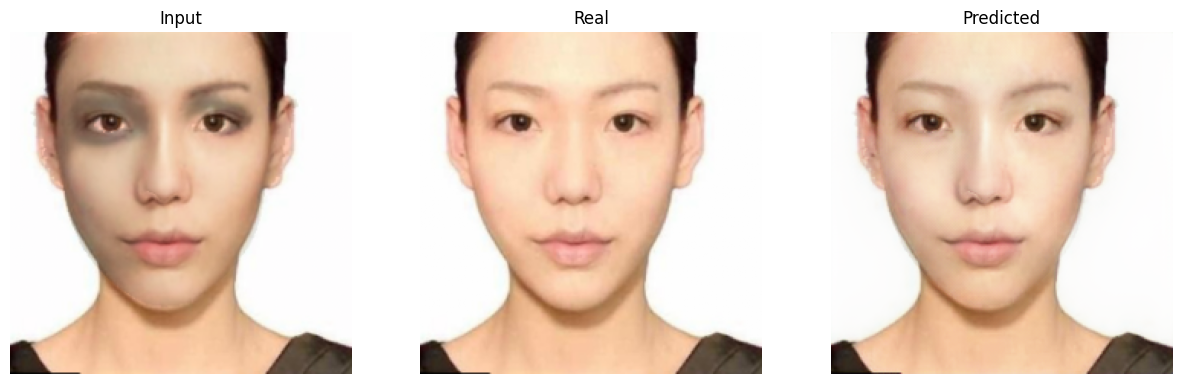

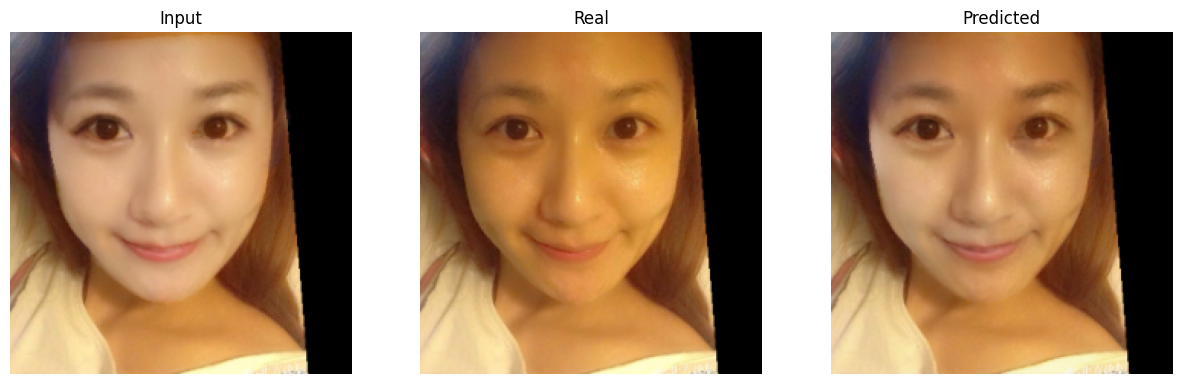

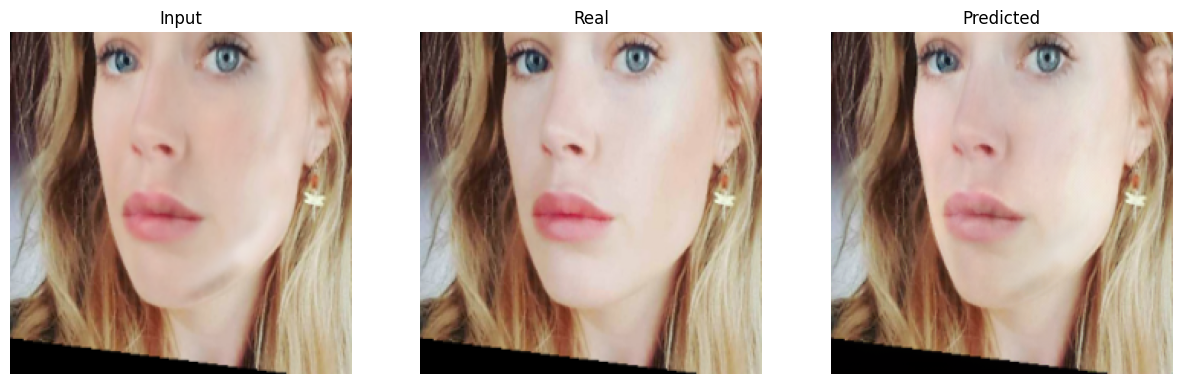

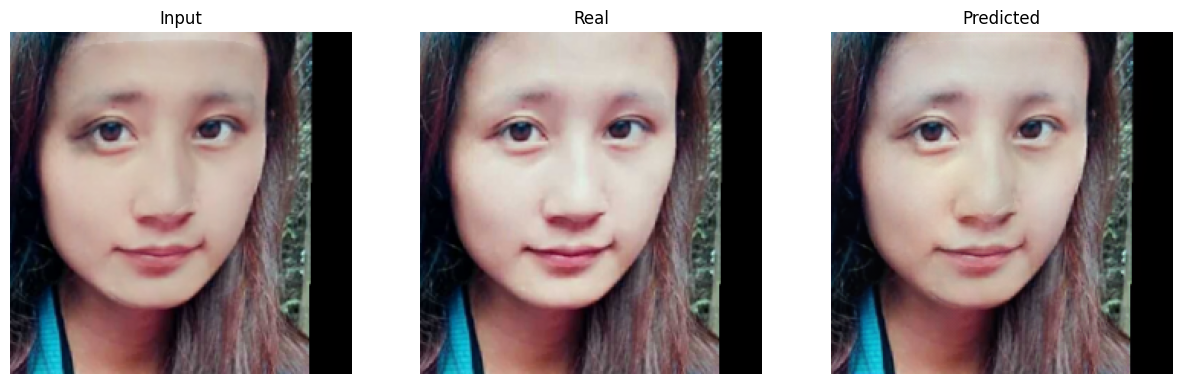

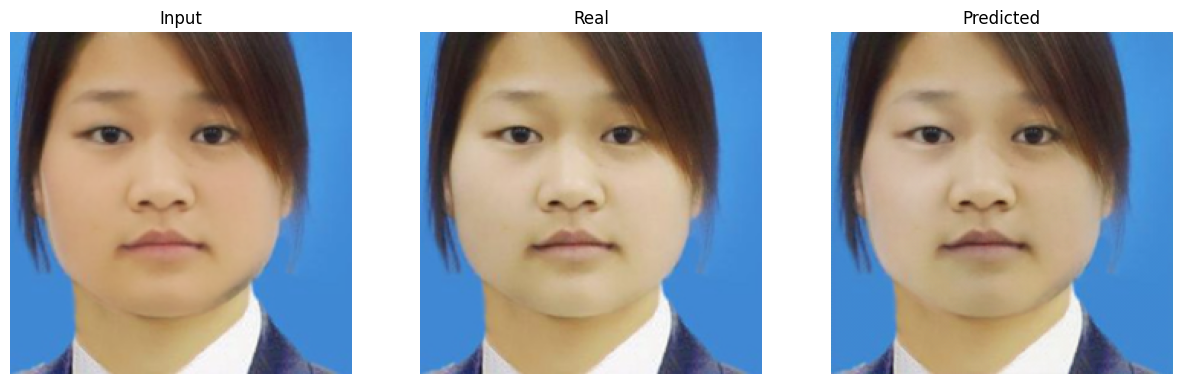

In [ ]:
for _ in range(5):
    inputs, targets = next(iter(valid_loader))

    input = inputs[0]
    target = targets[0]

    fake = model(input.unsqueeze(0).to(cfg.device))
    fake = fake.squeeze().data.cpu()

    plt.figure(figsize=(15,20))

    input = invTrans(input)
    
    display_list = [input.permute(1,2,0), target.permute(1,2,0), fake.permute(1,2,0)]
    
    title = ['Input', 'Real', 'Predicted']    

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()  